# Práctica 1
# Perceptrón multicapa con Keras

José Luis Ruiz Reina <br> Fernando Sancho Caparrini <br> Miguel A. Martínez del Amor <br>Miguel A. Gutiérrez Naranjo

_Versión del 29 de marzo de 2020_

 En esta práctica vamos a realizar algunos ejercicios simples con perceptrones multicapa (MLP) que nos van a servir de introducción al entorno de trabajo de Deep Learning con keras. Algunas consideraciones previas:
 
 * Se recomienda usar Anaconda y crear un entorno (environment) diferente para cada proyecto
 * En particular, se recomienda crea un entorno para usar tensorflow 1.x y otro para tensorflow 2.x
 * Si se dispone de un GPU local, se puede instalar keras con el comando 'conda install -c anaconda keras-gpu'
 * En otro caso, se puede subir este archivo a Google Drive y ejecutarlo cpn Google Colab.

*Keras* es una biblioteca Python que proporciona una interfaz para trabajar de manera cómoda y eficiente con redes neuronales y *Deep Learning* en general. El sistema *Keras* proporciona la interfaz a diversos sistemas Python especializados en Deep Learning, como *Tensorflow*, *Theano* o *CNTK*. En la actualidad podemos decir que es, junto con *Pytorch*, la interfaz más comúnmente usada para el desarrollo de aplicaciones que usan Deep Learning. 

En este cuaderno, veremos una muy breve introducción al uso de *Keras* para trabajar con redes neuronales multicapa, teniendo a *Tensorflow* como *backend*. *Tensorflow* es una biblioteca para Deep Learning, desarrollada por Google desde 2017, que permite construir y entrenar modelo basados en redes neuronales de manera muy eficiente. *Keras* nos proporciona una interfaz a *Tensorflow* de más alto nivel que si operáramos directamente con los métodos y estructuras de datos de *Tensorflow*.    

En Keras hay dos modos de representar las redes
* Secuential API
* Functional API

Empezamos con un experimento de Secuential API. Al final de la práctica veremos uno con la API funcional.

In [1]:
# Este trozo de código no es necesario
# pero sirve para evitar los warnings

from warnings import simplefilter
simplefilter(action = 'ignore',category = FutureWarning )

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Experimento 1

Este experimento está principamente basado en un ejemplo del capítulo 10 del libro:
 
**Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition**   
_Aurélien Géron_   
O'Reilly Media, Inc. 2019   

In [2]:
import numpy as np
import keras

Using TensorFlow backend.


In [3]:
# Comprobamos qué versión de keras estamos usando
keras.__version__

'2.2.4'

In [4]:
# También podemos comprobar qué versión de tensorflow estamos usando
tf.__version__

'1.14.0'

El conjunto de datos que vamos a tratar es *Fashion MNIST*, consistente en 70000 imágenes de distintos tipos de calzado y ropa, clasificados en 10 posibles clases. Las imágenes tienen un tamaño de 28x28 pixeles, cada uno de ellos codificado en escala de grises (de 0 a 255). Puedes tener más información de este conjunto de datos en https://github.com/zalandoresearch/fashion-mnist




En *Keras* tenemos una herramienta para cargar las imágenes directamente, con 60000 imágenes como conjunto de entrenamiento y 10000 en el conjunto de test:


In [5]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full_fashion, y_train_full_fashion), (X_test_fashion, y_test_fashion) = fashion_mnist.load_data()

Para poder tratar este conjunto de datos con redes neuronales, debemos tener en cuenta el formato de los datos:
* Cada ejemplo es bidimensional (28x28). 
* Las intensidades de los píxeles vienen dadas por números enteros.  

In [6]:
# El conjunto X_train_full es un tensor. Puedes imaginártelo como la superposición de 
# 60000 matrices 28 x 28, 
# donde en cada matriz, cada número representa la intensidad del píxel 

print(X_train_full_fashion.shape)
print(X_test_fashion.shape)
print(y_train_full_fashion.shape)
print(y_test_fashion.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


In [7]:
# Podemos ver que el tipo de dato (dtype) es "unsigned integer 8-bits"
X_train_full_fashion.dtype

dtype('uint8')

En el desarrollo de este ejemplo, como ya veremos,  nos será util tener un conjunto de validación. Este conjunto de validación puede verse como una porción del conjunto de entrenamiento sobre la que vamos a tomar medidas durante el proceso de entrenamiento. Nos quedamos con 55000 ejemplos en el conjunto de entrenamiento y 5000 para validación. Además, vamos a normalizar la intensidad de gris a un número entre 0 y 1, dividiendo por 255:   

In [8]:
X_valid_fashion, X_train_fashion = X_train_full_fashion[:5000] / 255., X_train_full_fashion[5000:] / 255.
y_valid_fashion, y_train_fashion = y_train_full_fashion[:5000], y_train_full_fashion[5000:]
X_test_fashion = X_test_fashion / 255.

Veamos una imagen en concreto, para hacernos una idea. 

In [9]:
import matplotlib.pyplot as plt

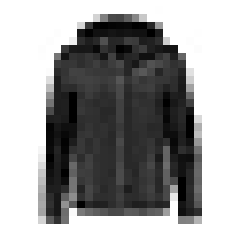

In [10]:
plt.imshow(X_train_fashion[0], cmap="binary")
plt.axis('off')
plt.show()

Las clases se codifican de 0 a 9, correspondiendo cada dígito a una de las clases que aparecen a continuación: 

In [11]:
y_train_fashion

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

In [12]:
y_train_fashion[0]

4

In [13]:
# Definimos el nombre que le queremos dara a cada uno de esos valores de clasificación (en castellano)

class_names = ["Camiseta", "Pantalón", "Chaleco", "Traje", "Abrigo",
               "Sandalia", "Camisa", "Zapatilla", "Bolso", "Botas"]

Podemos probar con varias imágenes

La clase de la imagen 59 es 0 y es Camiseta


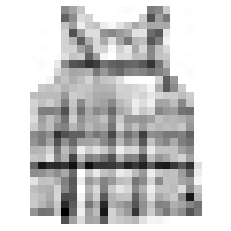

In [14]:
n_im = 59

print('La clase de la imagen',n_im,'es',y_train_fashion[n_im],'y es',class_names[y_train_fashion[n_im]])

plt.imshow(X_train_fashion[n_im], cmap="binary")
plt.axis('off')
plt.show()

Con el siguiente código podemos ver una pequeña muestra de las imágenes de las que consta el conjunto de datos:

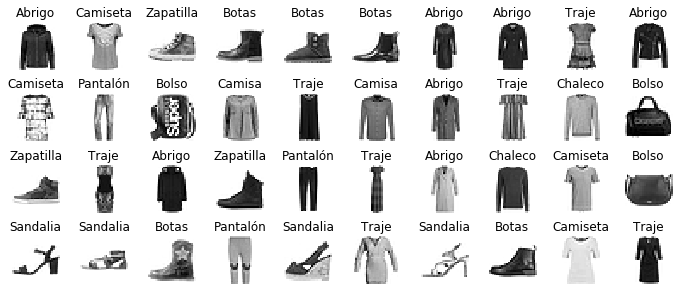

In [15]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train_fashion[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train_fashion[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Vamos a construir una red neuronal usando el módulo `Sequential` (tambén conocido como `Sequential` API). Para ello, simplemente añadimos capas (*layers*), indicando el tipo, el número de unidades y la función de activación: 

In [16]:
model_fashion = keras.models.Sequential()
model_fashion.add(keras.layers.Flatten(input_shape=[28, 28]))
model_fashion.add(keras.layers.Dense(300, activation="relu"))
model_fashion.add(keras.layers.Dense(100, activation="relu"))
model_fashion.add(keras.layers.Dense(10, activation="softmax"))

# Una manera alternativa de crear esta misma red sería:
#model_fashion = keras.models.Sequential([
#    keras.layers.Flatten(input_shape=[28, 28]),
#    keras.layers.Dense(300, activation="relu"),
#    keras.layers.Dense(100, activation="relu"),
#    keras.layers.Dense(10, activation="softmax")
#])

Comentemos en más detalles cada una de las capas:

* La primera capa (la de entrada), es una capa de tipo `Flatten` que nos va a servir para "aplana" los ejemplos bidimensionales (28x28) en ejemplos unidimensionales (784). Esta capa se limita a realizar un `X.reshape(-1,1)` a cada ejemplo `X` de entrada. Podemos considerar por tanto que tenemos 784 unidades en la capa de entrada. 
* Las dos capas siguientes son de tipo `Dense`, una con 300 unidades y la siguiente con 100 unidades, con función de activación ReLU. Cada unidad en una capa de tipo `Dense` recibe tantas conexiones como unidades en la capa anterior, más un sesgo. 
* En la útima capa (la de salida), tenemos 10 unidades (una por valor de clasificación), con función de activación softmax. Por tanto, debemos interpretar la salida de cada unidad como la probabilidad de pertenecer a la correspondiente clase.    

Una vez construido el modelo, el atributo `layers` será una lista con las correspondientes capas. Sin embargo, si consultamos su valor lo que obtenemos por pantalla no sirve de mucho. Es mejor usar `summary`:

In [17]:
model_fashion.layers

In [18]:
model_fashion.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


Para cada capa, se nos muestra:

* El tipo de la capa (flatten y densas, en este caso).
* El número de unidades de salida de cada capa (aquí `None` significa que puede recibir un número indeterminadao de ejemplos. salida de cada capa)
* El número de _parámetros_. Aquí por parámetro entendemos tanto pesos como sesgos. Veamos por qué tenemos esa cantidad de parámetros en cada capa:
   - La capa de entrada, por definición, no tiene parámetros (sólo se encarga de recoger los datos de entrada).
   - La primera capa oculta tiene 300 unidades y cada una recibe 784 conexiones y además hay que sumar los 300 sesgos: $300x784+300=235500$
   - La siguiente capa oculta es de 100 unidades. Por tanto son $300x100+100=30100$ parámetros
   - Por último, la capa de salida tiene $100x10+10=1010$ 
   
En total son 266610 parametros, una cantidad considerable si la comparamos con los modelos que hemos vsto hasta ahora. 

Podemos explorar los pesos iniciales y los sesgos, mediante `get_weights`. Por ejemplo, de la primera capa oculta (`layers[1]`) obtenemos los arrays de pesos y bias:

In [19]:
[weights1, biases1] = model_fashion.layers[1].get_weights()

Podemos ver el tamaño de cada uno de estos arrays:

In [20]:
weights1.shape, biases1.shape

((784, 300), (300,))

Podemos verlo con la segunda capa oculta y la de salida

In [21]:
[weights2, biases2] = model_fashion.layers[2].get_weights()
[weights3, biases3] = model_fashion.layers[3].get_weights()

print('La matiz de pesos de la segunda capa oculta tiene dim',weights2.shape,'y pesos',biases2.shape)
print('La matiz de pesos de la capa de salida tiene dim',weights3.shape,'y pesos',biases3.shape)

La matiz de pesos de la segunda capa oculta tiene dim (300, 100) y pesos (100,)
La matiz de pesos de la capa de salida tiene dim (100, 10) y pesos (10,)


Como hemos visto, la _matriz de pesos_ de cada capa tiene tantas filas como unidades tiene la capa anterior y tantas columnas como unidades tiene la propia capa. En el caso de la primera capa oculta 784 filas y 300 columnas. Es decir, cada fila se corresponde con los coeficientes de las conexiones de una unidad. Además, la matriz (unidimensional) de sesgos tiene tantos elementos como unidades tiene la capa (300 en este caso). 

Una vez hemos creado el modelo, vamos a pensar en el entrenamiento de la red. Para ello debemos indicar tres aspectos fundamentales:

* La función de pérdida, coste o `loss`. En este caso, usamos `sparse_categorical_crossentropy`, la más indicada cuando tenemos varias clases mutuamente excluyentes donde cada clase se representa con un dígito, como es este caso. El objetivo, por tanto, es encontrar los pesos que minimizan la entropía cruzada.
* El optimizador (`optimizer`), que es el método para buscar los pesos adecuados. En este caso, descenso estocástico por el gradiente, `sgd`.
* La métrica (`metrics`) que nos permitirá medir el rendimiento del modelo, tanto sobre el conjunto de entrenamiento como sobre los de validación y test. En este caso, usamos `accuracy`, que mide el porcentaje de aciertos en la clasificación que realiza el modelo. 

El método `compile` nos permite especificar estas tres cosas:


In [22]:
model_fashion.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

*Nota:* Podemos representar las etiquetas con la codificación one-hot y usar como función loss la "categorical_crossentropy" o podemos mantener las etiquetas representadas como enteros y usar la "sparse_categorical_crossentropy".

Ahora ya podemos entrenar el modelo, lo cual tomará algún tiempo. El método `fit` recibe el conjunto de entrenamiento, el número de _epochs_ y opcionalmente un conjunto de validación para ir midiendo el rendimiento durante el proceso. En cada epoch, se van a ir imprimiendo una serie de estadísticas, que comentamos más adelante. Las estadísticas del proceso de entrenamiento las guardaremos también en la variable `history`. 

In [23]:
history_fashion = model_fashion.fit(X_train_fashion, 
                                    y_train_fashion, 
                                    epochs=30,
                                    validation_data=(X_valid_fashion, y_valid_fashion))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 7s 125us/step - loss: 0.7146 - acc: 0.7645 - val_loss: 0.5327 - val_acc: 0.8186
Epoch 2/30
55000/55000 [==============================] - 7s 123us/step - loss: 0.4877 - acc: 0.8296 - val_loss: 0.4811 - val_acc: 0.8328
Epoch 3/30
55000/55000 [==============================] - 6s 115us/step - loss: 0.4421 - acc: 0.8464 - val_loss: 0.4244 - val_acc: 0.8534
Epoch 4/30
55000/55000 [==============================] - 7s 119us/step - loss: 0.4164 - acc: 0.8535 - val_loss: 0.3956 - val_acc: 0.8630
Epoch 5/30
55000/55000 [==============================] - 7s 120us/step - loss: 0.3955 - acc: 0.8618 - val_loss: 0.3801 - val_acc: 0.8700
Epoch 6/30
55000/55000 [==============================] - 7s 119us/step - loss: 0.3798 - acc: 0.8668 - val_loss: 0.3752 - val_acc: 0.8708
Epoch 7/30
55000/55000 [==============================] - 7s 122us/step - loss: 0.3663 - acc: 0.8708 - val_loss: 0.3745 - v

Por cada epoch, se ha ido imprimiendo la pérdida del modelo tanto sobre el conjunto de entrenamiento como sobre el de validación. Además el rendimiento (`accuracy` en este caso) igualmente sobre el entrenamiento y sobre validación.  

Como se observa, el rendimiento final sobre el conjunto de validación es cercano al 90%, lo cual está bastante bien.

Como decíamos, en `history_fashion` tenemos una serie de datos sobre el entrenamiento:

In [24]:
history_fashion.params

{'batch_size': 32,
 'epochs': 30,
 'steps': None,
 'samples': 55000,
 'verbose': 1,
 'do_validation': True,
 'metrics': ['loss', 'acc', 'val_loss', 'val_acc']}

En particular, `history_fashion.history` es un diccionario que contiene los datos de pérdida y rendimiento que se han ido imprimiendo para cada epoch. Esto nos permite hacer una gráfica en la que vemos la evolución de ambas funciones, tanto sobre entrenamiento como sobre validación. 

In [25]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (15,5) # Para el tamaño de la imagen
mpl.rcParams['figure.figsize'] = (15,5)

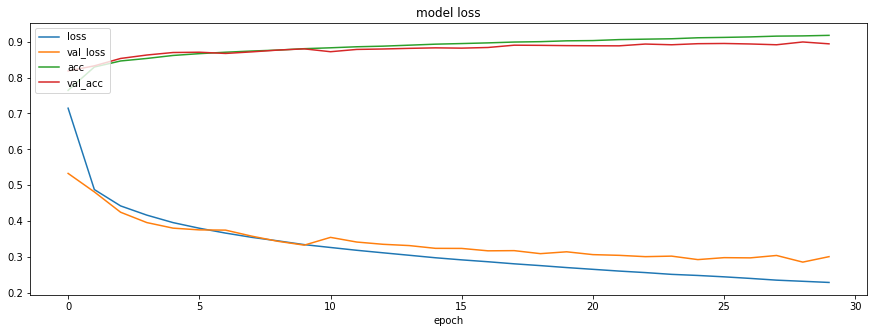

In [26]:
plt.plot(history_fashion.history['loss'], label = 'loss')
plt.plot(history_fashion.history['val_loss'], label = 'val_loss')
plt.plot(history_fashion.history['acc'], label = 'acc')
plt.plot(history_fashion.history['val_acc'], label = 'val_acc')
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['loss','val_loss','acc','val_acc'], loc ='upper left')
plt.show()

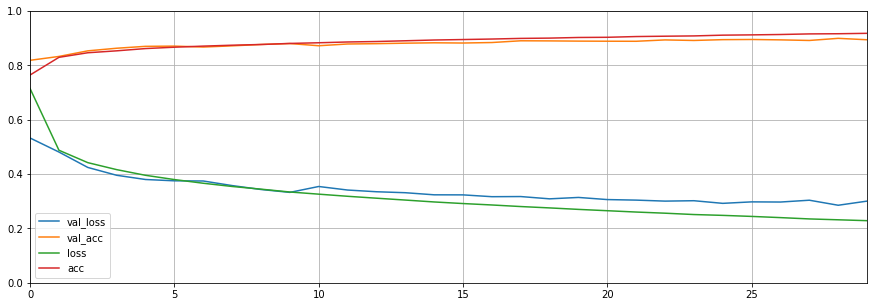

In [27]:
# También podemos obtener la representación gráfica usando el paquete pandas

import pandas as pd

pd.DataFrame(history_fashion.history).plot(figsize=(15, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

En la gráfica anterior se observa que a medida que transcurren los epochs se consigue el objetivo de bajar la función de pérdida sobre el conjunto de entrenamiento (y aumentar el rendimiento). También vemos que (aunque obviamente un poco peor), igualmente se rebaja la pérdida sobre el conjunto de validación y se aumenta el rendimiento, lo que quiere decir que no hay sobreajuste. 

Veamos ahora el rendimiento sobre el conjunto de prueba, también bastante bueno. Los valores obtenidos son la medida de error (loss) y las métricas que hemos usado (accuracy en este caso) sobre le conjunto de test.

In [28]:
test_loss, test_acc = model_fashion.evaluate(X_test_fashion, y_test_fashion)
print('\nError (loss) sobre el conjunto de test:',test_loss)
print('Rendimiento (accuracy) sobre el conjunto de test:',test_acc)

10000/10000 [==============================] - 0s 41us/step

Error (loss) sobre el conjunto de test: 0.33122344014048577
Rendimiento (accuracy) sobre el conjunto de test: 0.8795


Para finalizar, veamos la predicción (`predict`) sobre los tres primeros ejemplos del conjunto de test, y comprobemos si se ha acertado:

In [29]:
X_new_fashion = X_test_fashion[:3]
y_proba_fashion = model_fashion.predict(X_new_fashion)
y_proba_fashion.round(2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Lo anterior son las probabilidades que se predicen para cada clase, en cada uno de los tres ejemplos. En el primer caso, la probabilidad mayor es la de la última clase (Botas), en el segundo es la clase tercera (Chaleco) y en tercero es la segunda clase (Pantalón). Podemos usar  el método `predict_classes` para ver las clases concretas que se predicen:

In [30]:
y_pred_fashion = model_fashion.predict_classes(X_new_fashion)
y_pred_fashion

array([9, 2, 1])

In [31]:
np.array(class_names)[y_pred_fashion]

array(['Botas', 'Chaleco', 'Pantalón'], dtype='<U9')

En este caso, se acierta en los tres ejemplos:

In [32]:
y_new_fashion = y_test_fashion[:3]
y_new_fashion

array([9, 2, 1], dtype=uint8)

Podemos incluso ver las imágenes, comprobando los aciertos:

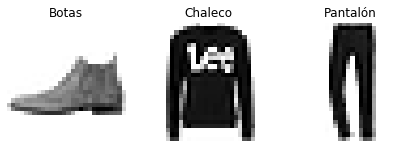

In [33]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new_fashion):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test_fashion[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
#save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

Puesto que la salida de la última capa es una distribución de probabilidad, podemos también representar la probabilidad de cada una de las categorías.

In [34]:
# Código tomado de https://www.tensorflow.org/tutorials/keras/classification

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Podemos usar ese código para representar la salida de la red.

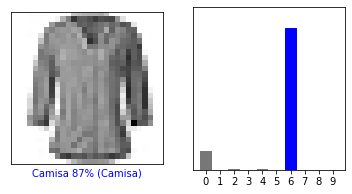

In [35]:
y_pred_fashion_test = model_fashion.predict(X_test_fashion)

i = 4
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
# plot_image(i, predictions[i], test_labels, test_images)
plot_image(i, y_pred_fashion_test, y_test_fashion, X_test_fashion)
plt.subplot(1,2,2)
plot_value_array(i, y_pred_fashion_test[i],  y_test_fashion)
#plot_value_array(i, predictions[i],  test_labels)
plt.show()

Es interesante ver qué ocurre con los ejemplos en los que hay dos categorías con probabilidad alta. Por ejemplo, si vemos la salida de la red en el ejmplo 4.

In [36]:
y_pred_fashion_test[4].round(2)

array([0.12, 0.  , 0.01, 0.  , 0.01, 0.  , 0.87, 0.  , 0.  , 0.  ],
      dtype=float32)

Vemos que la categoría 6 (Camisa) tiene una probabilidad de 0.47 (aprox.) y que la categoría 1 (Camiseta) tiene probabilidad 0.44. ¿Debemos fiarnos de esa clasificación cuando la diferencia es tan ajustada?

Podemos representar la distribución de probabilidad asociada a otras imágenes con elsiguiente código.

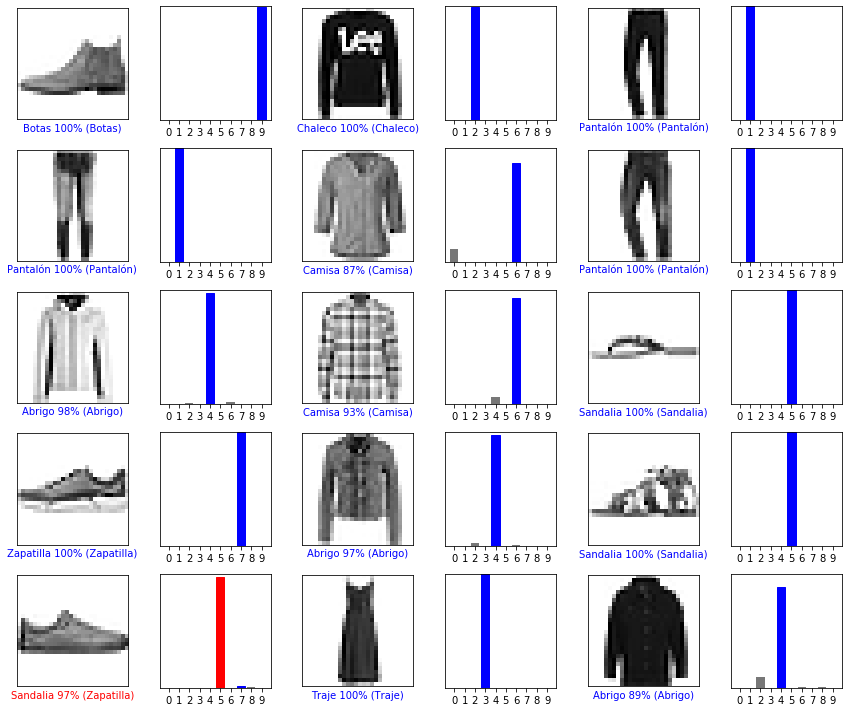

In [37]:
# Representamos la predicción correcta en azul y si es incorrecta en rojo

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
#  plot_image(i, predictions[i], test_labels, test_images)
  plot_image(i, y_pred_fashion_test, y_test_fashion, X_test_fashion)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
#  plot_value_array(i, predictions[i], test_labels)
  plot_value_array(i, y_pred_fashion_test[i],  y_test_fashion) 
plt.tight_layout()
plt.show()


# Experimento 2

En este segundo experimento vamos a basarnos en otro de los más famosos conjuntos de ejemplos, el conjunto de imágenes MNIST, formado por imágenes de dígitos escritos a mano. Puedes obtener información sobre este conjunto en http://yann.lecun.com/exdb/mnist/. Aquí seguimos un ejemplo tomado de la web de keras https://keras.io/examples/mnist_mlp/

In [38]:
# Cargamos las librerías

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

In [39]:
# Cargamos el conjunto MNIST.

from keras.datasets import mnist

In [40]:
# Cargamos el dataset con load.
# En este caso ya está separado en entrenamiento y prueba
(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()

In [41]:
# Usamos 60000 ejemplos para entrenar y 10000 ejemplo para el test
# x_train es un tensor formado por 60000 matrices de tamaño 28 x 28
print(X_train_mnist.shape)
print(X_test_mnist.shape)

(60000, 28, 28)
(10000, 28, 28)


In [42]:
# Obtenemos el primer ejemplo. Es una matriz (array) de 28 x 28 valores.
X_train_mnist[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [43]:
# No nos dice mucho. Obtengamos algo de información del primer ejemplo.

print('Tamaño:', X_train_mnist[0].shape)
print('Valor máximo:',np.amax(X_train_mnist[0]))
print('Valor mínimo:',np.amin(X_train_mnist[0]))

Tamaño: (28, 28)
Valor máximo: 255
Valor mínimo: 0


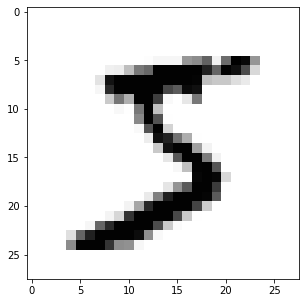

In [44]:
# Es una matriz de 28 x 28 con valores enteros entre 0 y 255
# La interpretamos como una imagen en escala de grises.
plt.imshow(X_train_mnist[0], cmap='Greys')
plt.show()

In [45]:
# Está clasificado como 5
print(y_train_mnist[0]) 

5


La etiqueta del ejemplo 3452 es 3


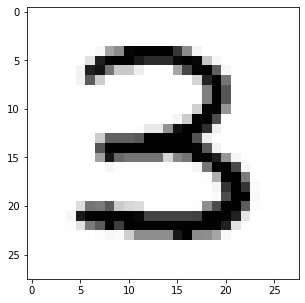

In [46]:
# Probamos con otros índices

indice_prueba = 3452
plt.imshow(X_train_mnist[indice_prueba], cmap='Greys')
print('La etiqueta del ejemplo',indice_prueba,'es',y_train_mnist[indice_prueba]) 

In [47]:
# En el Experimento 1 usábamos una primera capa Flatten para cambiar las dimensiones de los tensores. 
# Esto también se puede hacer aparte

X_train_m_reshaped = X_train_mnist.reshape(60000, 784).astype('float32') / 255
X_test_m_reshaped = X_test_mnist.reshape(10000, 784).astype('float32') /255

print(X_train_m_reshaped.shape[0], 'train samples')
print(X_test_m_reshaped.shape[0], 'test samples')

60000 train samples
10000 test samples


In [48]:
print('Cada ejemplo es ahora un vector de longitud',X_train_m_reshaped.shape[1])

Cada ejemplo es ahora un vector de longitud 784


In [49]:
# En este experimento vamos a usar la representación one-hot para las etiquetas

num_classes= 10

y_train_m_reshaped = keras.utils.to_categorical(y_train_mnist, num_classes)
y_test_m_reshaped = keras.utils.to_categorical(y_test_mnist, num_classes)

In [50]:
# Vemos la primera etiqueta, que como hemos visto antes, corresponde al 5
y_train_m_reshaped[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [51]:
# Creamos el modelo

model_mnist = Sequential()
model_mnist.add(Dense(512, activation='relu', input_shape=(784,)))
model_mnist.add(Dense(512, activation='relu'))
model_mnist.add(Dense(num_classes, activation='softmax'))

In [52]:
# Vemos qué pinta tiene
model_mnist.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [53]:
# Compilamos

model_mnist.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [54]:
# Entrenamos. En este caso vamos a usar como conjunto de validación el mismo conjunto que para test

mi_batch_size = 128
mis_epochs = 20

history_mnist = model_mnist.fit(X_train_m_reshaped, y_train_m_reshaped,
                    batch_size=mi_batch_size,
                    epochs=mis_epochs,
                    verbose=1,
                    validation_data=(X_test_m_reshaped, y_test_m_reshaped))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 4s 75us/step - loss: 0.2200 - acc: 0.9326 - val_loss: 0.1238 - val_acc: 0.9624
Epoch 2/20
60000/60000 [==============================] - 4s 69us/step - loss: 0.0823 - acc: 0.9742 - val_loss: 0.0928 - val_acc: 0.9713
Epoch 3/20
60000/60000 [==============================] - 4s 70us/step - loss: 0.0530 - acc: 0.9839 - val_loss: 0.0821 - val_acc: 0.9780
Epoch 4/20
60000/60000 [==============================] - 4s 72us/step - loss: 0.0387 - acc: 0.9880 - val_loss: 0.0731 - val_acc: 0.9792
Epoch 5/20
60000/60000 [==============================] - 4s 72us/step - loss: 0.0295 - acc: 0.9905 - val_loss: 0.0768 - val_acc: 0.9822
Epoch 6/20
60000/60000 [==============================] - 4s 69us/step - loss: 0.0221 - acc: 0.9931 - val_loss: 0.1191 - val_acc: 0.9721
Epoch 7/20
60000/60000 [==============================] - 4s 69us/step - loss: 0.0193 - acc: 0.9941 - val_loss: 0.1040 - val_acc

In [55]:
# Podemos guardar el modelo ya entrenado como un fichero HDF5
# Esto nos permite volver a usar los pesos entrenados en otra sesión
model_mnist.save('my_model.h5') 

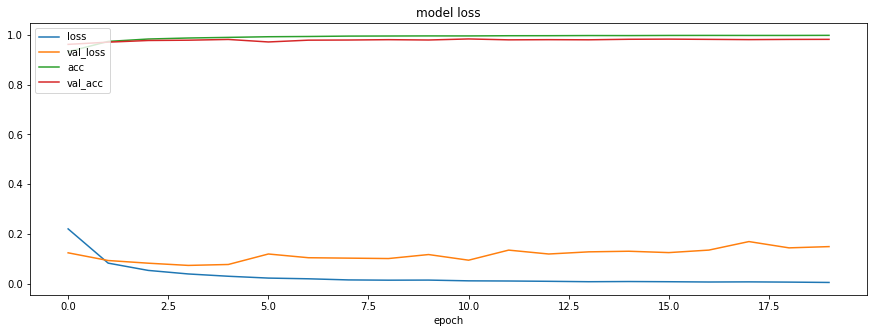

In [56]:
# Vemos cómo ha ido la evolución

plt.plot(history_mnist.history['loss'], label = 'loss')
plt.plot(history_mnist.history['val_loss'], label = 'val_loss')
plt.plot(history_mnist.history['acc'], label = 'acc')
plt.plot(history_mnist.history['val_acc'], label = 'val_acc')
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['loss','val_loss','acc','val_acc'], loc ='upper left')
plt.show()

In [57]:
# Vemos el error y la medida de rendimiento (accuracy) obtenida
test_m_loss, test_m_acc = model_mnist.evaluate(X_test_m_reshaped, y_test_m_reshaped)
print('Test loss:',test_m_loss)
print('Test accuracy:',test_m_acc)

10000/10000 [==============================] - 0s 39us/step
Test loss: 0.14874750428100614
Test accuracy: 0.9826


Nótese que son los valores obtenidos tras el último paso de entrenamiento, ya que hemos usado el conjunto de test como conjunto de validación.

In [58]:
# Podemos ver las predicciones sobre los tres primeros dígitos del conjunto de test

X_new_m = X_test_m_reshaped[:3]
y_proba_m = model_mnist.predict(X_new_m)
y_proba_m.round(2)

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [59]:
# Deshaciendo el one-hot encoding, vemos las clases a las que corresponden
y_pred = model_mnist.predict_classes(X_new_m)
y_pred

array([7, 2, 1])

In [60]:
# Comprobamos cuáles eran las etiquetas reales
y_test_mnist[:3]

array([7, 2, 1], dtype=uint8)

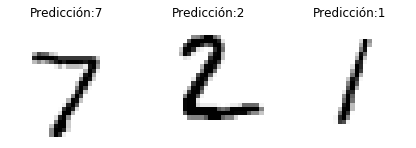

In [61]:
# Podemos representar las imágenes junto a sus predicciones

plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_test_mnist[:3]):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title('Predicción:' + str(y_pred[index]), fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

También podemos considerar la matriz de confusión de este experimento

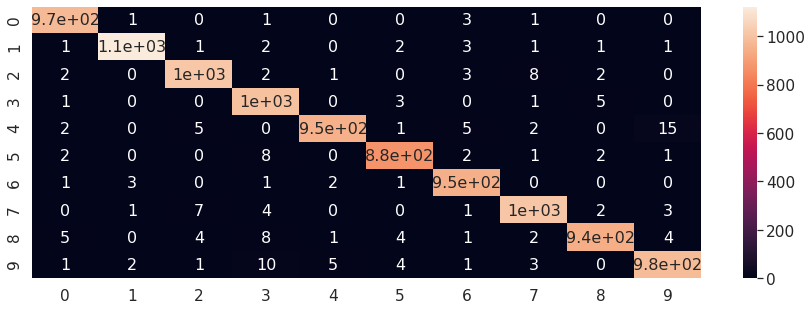

In [62]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

import seaborn as sn
import pandas as pd


Y_pred_test_classes = model_mnist.predict_classes(X_test_m_reshaped)
confusion_mtx = confusion_matrix(y_test_mnist, Y_pred_test_classes) 


df_cm = pd.DataFrame(confusion_mtx, range(10), range(10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size


También puede ser interesante buscar los números en los que la clasificación no ha sido la correcta

In [63]:
y_pred_fashion_test

array([[1.1208414e-06, 1.9259044e-08, 9.2397534e-07, ..., 2.3325437e-03,
        3.0780080e-05, 9.9590802e-01],
       [1.7192460e-05, 1.6325313e-09, 9.9596196e-01, ..., 8.9281716e-12,
        7.8278859e-08, 2.6727717e-10],
       [1.5621459e-05, 9.9997616e-01, 9.7731936e-07, ..., 1.2621599e-09,
        4.2990544e-09, 4.7100136e-12],
       ...,
       [3.3633541e-03, 1.3493857e-07, 8.3117955e-04, ..., 3.9383303e-06,
        9.9436355e-01, 1.8395083e-07],
       [4.5642737e-05, 9.9958438e-01, 1.7963053e-05, ..., 5.3836987e-07,
        5.7344550e-07, 2.7403419e-07],
       [1.3990249e-05, 4.7581229e-06, 7.8560071e-05, ..., 4.6794461e-03,
        1.3971784e-03, 6.9735848e-05]], dtype=float32)

In [64]:
y_pred_m_test_prob = model_mnist.predict(X_test_m_reshaped)
y_pred_m_test_prob[0]

array([0.0000000e+00, 4.0714152e-32, 4.6400328e-30, 4.9788597e-24,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
       4.8576332e-37, 2.0620883e-25], dtype=float32)

Salida de la red: [0.   0.26 0.   0.   0.   0.   0.   0.   0.   0.74]
Predicción: 9
Clasificación real: 1


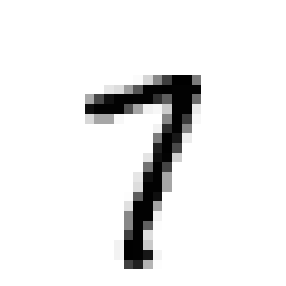

In [65]:
y_pred_m_test = model_mnist.predict_classes(X_test_m_reshaped)

indices_m_diff = [i for i in range(len(y_test_mnist)) if y_test_mnist[i] != y_pred_m_test[i]]

diff_i = 0

diff_j = indices_m_diff[diff_i]

print('Salida de la red:',y_pred_m_test_prob[diff_j].round(2))
print('Predicción:',y_pred_m_test[diff_j])
print('Clasificación real:',y_test_mnist[diff_j])

plt.imshow(X_train_mnist[diff_j], cmap='Greys')
plt.axis('off')
plt.show()

Para terminar este experimento, escribe un número en un lienzo de 28 x 28 píxeles. Guárdalo en un fichero con nombre 'mi_numero.jpg' y prueba a ver si la red lo clasifica correctamente.

In [66]:
from keras.preprocessing import image
import os

def mi_pred(file):
    cwd = os.getcwd() # cwd es el directorio actual
    mi_imagen = image.load_img(cwd + '/' + file +'.jpg',color_mode='grayscale',target_size=(28,28))    
    mi_array_aux = image.img_to_array(mi_imagen)
    mi_array = 255 - mi_array_aux
    mi_imagen_inversa = image.array_to_img(mi_array)
    mi_array_reshape = mi_array.reshape(1,784)
    pred = model_mnist.predict(mi_array_reshape)
    b = np.argmax(pred)
    print('')
    print('Predicción: ',b)
    plt.axis('off')
    plt.imshow(mi_imagen_inversa,cmap='Greys')


Predicción:  9


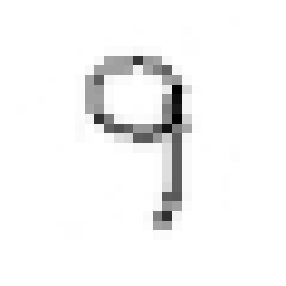

In [67]:
mi_pred('mi_numero')

# Experimento 3

Tomado del libro **Deep Learning with Python** de F. Chollet

La clasificación binaria es, posiblemente, el tipo de problema con mayor número de aplicaciones en ML. En este experimento vamos a ver cómo construir un clasificador en Keras. Concretamente, construiremos una red neuronal que nos ayude a clasificar opiniones de películas como "positivas/negativas" únicamente basándonos en el contenido textual de las mismas. Será un ejemplo de lo que se conoce actualmente como **Análisis de Sentimientos**.

Usaremos uno de los datasets que proporciona el sitio [IMDB](https://www.imdb.com) (Internet Movie DataBase) formado por 50,000 opiniones altamente polarizadas (lo que simplifica la tarea de aprendizaje). Este conjunto está dividido en 50%/50% para entrenamiento/test, y en cada uno de ellos hay un 50% de opiniones de cada tipo.

Al igual que con el dataset anterior (MNIST) este dataset también viene con Keras, y además se proporciona preprocesado: por medio de un diccionario indexado, las opiniones (secuencias de palabras) se han convertido en secuencias de enteros.

In [68]:
# Nota: imdb.load_data está probado para numpy 1.16.1. En versiones posteriores falla
# porque el valor por defecto de allow_pickle en np.load ha cambiado.

from keras.datasets import imdb

(imdb_train_data, imdb_train_labels), (imdb_test_data, imdb_test_labels) = imdb.load_data(num_words=10000)

Como el diccionario es tremendamente grande y hay muchas palabras que se usan rara vez, nos quedaremos solo con las 10,000 palabras más frecuentes (algo que conseguimos por medio del argumento num_words = 10000 en el proceso de carga).

Si quieres, puedes explorar el contenido de las variables train_data y test_data, que son listas de opiniones, donde cada opinión es una lista de enteros (codificando una secuencia de palabras). Las variables train_labels y test_labels son listas binarias, donde 0 indica que la opinión asociada es negativa y 1 que es positiva:


In [69]:
# Vemos qué aspecto tiene el primer ejemplo
print(imdb_train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [70]:
# Pues como ese, hay 25000
imdb_train_data

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 8255, 78, 228,

In [71]:
# Vemos las 5 primeras etiquetas
imdb_train_labels[:5]

array([1, 0, 0, 1, 0])

In [72]:
print('train_data tiene', len(imdb_train_data),'ejemplos')
print('cada uno de ellos con',len(imdb_train_data[0]),'valores (atributos)')

train_data tiene 25000 ejemplos
cada uno de ellos con 218 valores (atributos)


Puedes observar que los índices de las palabras almacenadas están por debajo de 10,000:

In [73]:
max([max(sequence) for sequence in imdb_train_data])

9999

Aunque no es necesario para el entrenamiento posterior, podemos construir funciones que reconstruyen las opiniones a partir de las secuencias de índices:

In [74]:
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in imdb_train_data[0]])

In [75]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

Como las redes neuronales no admiten listas de enteros como entrada, porque son de longitud variable, hemos de añadir un preprocesado adicional para poder trabajar con ellas. Tenemos dos opciones:

* Completar las listas más cortas para que todas tengan la misma longitud y, entonces, convertirlas en tensores que alimentarán la capa de entrada de la red.
* Codificar en One-hot las listas para convertirlas en vectores de 0s y 1s. Como tenemos un máximo de 10,000 palabras en nuestro vocabulario, cada opinión se convertirá en una lista binaria de 10,000 posiciones indicando qué palabras aparecen en la opinión. En este caso, la primera capa (densa) de nuestra red se conectaría con vectores de longitud 10,000.

Optaremos por esta segunda opción, que con el tiempo veremos que tiene más ventajas que la primera. 

El código que permite hacer esta conversión es:

In [76]:
#función para tratar los datos de entrada de la red
def vectorize_sequences(sequences, dimension=10000):
    # Primero creo results, que es una matriz llena de ceros
    # que tiene tantas filas como ejemplos haya en "sequences"
    # y 10000 columnas (tantas como palabras estoy usando)
    results = np.zeros((len(sequences), dimension))
    # para cada ejemplo que aparezca en sequences
    for i, sequence in enumerate(sequences):
        # Cambio el cero de la posición (i,sequence por un 1)
        results[i, sequence] = 1.
    return results

In [77]:
# Lo vemos con el primer ejemplo de train_data
# Comprobamos que el 1 y el 2 sí aparecen en el primer ejemplo, pero que el 0 y el 3 no

print(imdb_train_data[0])
print('\n¿Está el 0 en la lista?', 0 in imdb_train_data[0])
print('¿Está el 1 en la lista?', 1 in imdb_train_data[0])
print('¿Está el 2 en la lista?', 2 in imdb_train_data[0])
print('¿Está el 3 en la lista?', 3 in imdb_train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]

¿Está el 0 en la lista? False
¿Está el 1 en la lista? True


In [78]:
# Si ahora aplicamos vectorice_sequences al primer ejemplo de train_data
# vemos que en la posición 0 y 3 sigue habiendo un cero, pero que en las posiciones 1 y 2 hay un 1.
# Esto no es más que una forma de representar la información, pero hay que tener en cuenta que 0 significa que
# la palabra noa aparece y 1 que sí aparece, pero estamos perdiendo mucha información porque
# nos da aigual qué palabra venía delante o detrás o el número de veces que aparecía.
vectorize_sequences([imdb_train_data[0]])[0][:10]

array([0., 1., 1., 0., 1., 1., 1., 1., 1., 1.])

In [79]:
# Vectorizamos el conjunto de entrenamiento
x_train_imdb = vectorize_sequences(imdb_train_data)
# Vectorizamos el conjunto de test
x_test_imdb = vectorize_sequences(imdb_test_data)

In [80]:
print('x_train tiene', len(x_train_imdb),'ejemplos')
print('cada uno de ellos con',len(x_train_imdb[0]),'valores (atributos)')

x_train tiene 25000 ejemplos
cada uno de ellos con 10000 valores (atributos)


Este es el aspecto que tienen ahora las opiniones. Nótese que sólo marcamos si la palabra aparece o no. No distinguimos si aparece una vez o varias.

In [81]:
x_train_imdb

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

Para las etiquetas, lo único que hacemos es cambiar el tipo de datos y pasarlas a punto flotante.

In [82]:
y_train_imdb = np.asarray(imdb_train_labels).astype('float32')
y_test_imdb = np.asarray(imdb_test_labels).astype('float32')

Definimos la red

In [83]:
model_imdb = Sequential()
# La primer capa oculta tiene 16 neuronas. Recibe datos de la primera capa, que tiene 10000 neuronas. 
# Su función de activación es relu
model_imdb.add(Dense(16, activation='relu', input_shape=(10000,)))
# La segunda capa oculta tiene 16 neuronas y función relu. 
# No hace falta decir cuántas neuronas tiene ca capa anterior, keras ya se da cuenta
model_imdb.add(Dense(16, activation='relu'))
# La última capa tiene una única neurona con función sigmoide. Con eso la salida es un valor 
# comprendido entre 0 y 1. 
model_imdb.add(Dense(1, activation='sigmoid'))

In [84]:
model_imdb.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


Además del 'model.summary()', otra forma de visualizar la red es con la utilidad 'plot_model', que permite guardar en un fichero un esquema de la red.

In [85]:
from keras.utils.vis_utils import plot_model

plot_model(model_imdb, to_file='IMDBModel_plot.png', show_shapes=True, show_layer_names=True)

La imagen guardada en el fichero es la siguiente:

![](./IMDBModel_plot.png)

Siguiendo el mismo patrón que vimos en el ejemplo anterior, necesitamos elegir la función de pérdida (que será minimizada) y el método de optimización (que será el que busque minimizar esa función). 

Como estamos ante un problema de clasificación binaria y la salida de nuestra red es una probabilidad (proporcionada por la sigmoide), usaremos `binary_crossentropy` como función de pérdida. No es la única opción viable, podríamos haber elegido, por ejemplo, `mean_squared_error`, pero en este caso `binary_crossentropy` es una mejor opción por estar trabajando con probabilidades. La entropía cruzada proviene del campo de **Teoría de la Información**, y mide la distancia entre distribuciones de probabilidad (en este caso, la distribución calculada por el predictor y la que representa la distribución _real_ proveniente de los datos de entrenamiento).

Como optimizador usaremos `rmsprop`, que suele ser una buena elección en casi todos los casos. Para monitorizar la evolución del aprendizaje usaremos una sola métrica, _accuracy_.

In [86]:
from keras import optimizers

model_imdb.compile(optimizer=optimizers.RMSprop(lr=0.001), # learning rate = 0.001
              loss='binary_crossentropy',
              metrics=['accuracy'])


Con el fin de monitorizar la métrica (_accuracy_) mientras se produce el entrenamiento necesitamos tener más datos que el modelo no use durante el proceso. Crearemos para ello un *conjunto de validación* separando otras 10,000 muestras del conjunto original. Así pues la situación queda como:

* _Conjunto de entrenamiento_: con el que intentaremos optimizar los pesos de la red para que minimice la función de pérdida. En este proceso se usa un modelo que depende de ciertos parámetros que quizás deban ser ajustados para conseguir mejorar el rendimiento.

* _Conjunto de validación_: con el que se medirá cómo de bueno es el modelo concreto que estamos entrenando (con unos parámetros fijos). Es algo así como un conjunto de test temporal. Permite ajustar estos parámetros para mejorar el rendimiento.

* _Conjunto de test_: que no se ha usado en ningún momento de las iteraciones anteriores y que permite medir de forma objetiva la bondad del modelo final obtenido.

In [87]:
x_val_imdb = x_train_imdb[:10000]
partial_x_train_imdb = x_train_imdb[10000:]

y_val_imdb = y_train_imdb[:10000]
partial_y_train_imdb = y_train_imdb[10000:]

A continuación, entrenaremos el modelo realizando 20 iteraciones (_epochs_) sobre el conjunto completo de entrenamiento, ni validación, ni test), en mini-batches de 512 muestras (es decir, cada 512 muestras analizadas, se actualizan los pesos de la red). Monitorizaremos _loss_ y _accuracy_ sobre las 10,000 muestras que dejamos en el conjunto de validación. Para ello, usamos el argumento `validation_data` de la función `fit`, que no usamos en el ejemplo anterior:

In [88]:
history_imdb = model_imdb.fit(partial_x_train_imdb,
                    partial_y_train_imdb,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val_imdb, y_val_imdb))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 150us/step - loss: 0.5084 - acc: 0.7813 - val_loss: 0.3797 - val_acc: 0.8684
Epoch 2/20
15000/15000 [==============================] - 1s 98us/step - loss: 0.3004 - acc: 0.9047 - val_loss: 0.3004 - val_acc: 0.8897
Epoch 3/20
15000/15000 [==============================] - 1s 93us/step - loss: 0.2179 - acc: 0.9285 - val_loss: 0.3085 - val_acc: 0.8711
Epoch 4/20
15000/15000 [==============================] - 1s 97us/step - loss: 0.1750 - acc: 0.9437 - val_loss: 0.2840 - val_acc: 0.8832
Epoch 5/20
15000/15000 [==============================] - 1s 98us/step - loss: 0.1427 - acc: 0.9543 - val_loss: 0.2841 - val_acc: 0.8872
Epoch 6/20
15000/15000 [==============================] - 1s 97us/step - loss: 0.1150 - acc: 0.9650 - val_loss: 0.3166 - val_acc: 0.8772
Epoch 7/20
15000/15000 [==============================] - 1s 97us/step - loss: 0.0980 - acc: 0.9705 - val_loss: 0.3127 - val_ac

Vemos cómo ha ido el entrenamiento.

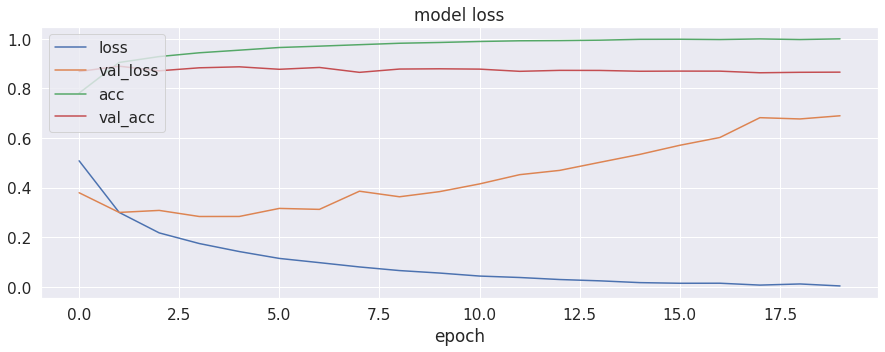

In [89]:
plt.plot(history_imdb.history['loss'], label = 'loss')
plt.plot(history_imdb.history['val_loss'], label = 'val_loss')
plt.plot(history_imdb.history['acc'], label = 'acc')
plt.plot(history_imdb.history['val_acc'], label = 'val_acc')
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['loss','val_loss','acc','val_acc'], loc ='upper left')
plt.show()

Estas gráficas muestras que la _pérdida_ de entrenamiento decrece en cada epoch, y que el _accuracy_ en entrenamiento crece, algo que indica que el procedimiento de optimización está funcionando adecuadamente (sobre todo respecto a la función de pérdida). Pero en este caso observamos que no ocurre lo mismo con la validación, que empiezan a empeorar a partir de la epoch 4. Estamos ante un claro caso de *overfitting*: tras unos pocos pasos el sistema se sobreajusta a los datos de entrenamiento, y aprende una representación que es específica a estos datos y que no puede generalizarse a otros datos.

En este caso, para prevenir el overfitting podríamos parar el entrenamiento tras las 3 primeras iteraciones. Más adelante veremos algunas otras técnicas para mitigar este efecto, pero por ahora nos contentaremos con este procedimiento que, aún lejos de ser el mejor, evita este problema ahora mismo.

Vamos a entrenar una nueva red desde el principio pero solo durante 4 epochs y después evaluaremos el modelo sobre los datos de test (observa que estos datos no los hemos usado en ningún momento hasta ahora):

In [90]:
model_imdb_2 = Sequential()
model_imdb_2.add(Dense(16, activation='relu', input_shape=(10000,)))
model_imdb_2.add(Dense(16, activation='relu'))
model_imdb_2.add(Dense(1, activation='sigmoid'))

model_imdb_2.compile(optimizer=optimizers.RMSprop(lr=0.001), # learning rate = 0.001
              loss='binary_crossentropy',
              metrics=['accuracy'])


model_imdb_2.fit(partial_x_train_imdb,
                    partial_y_train_imdb,
                    epochs=4,
                    batch_size=512,
                    validation_data=(x_val_imdb, y_val_imdb))

imdb_2_test_loss, imdb_2_test_acc = model_imdb_2.evaluate(x_test_imdb, y_test_imdb)

print('\nError (loss) sobre el conjunto de test:',imdb_2_test_loss)
print('Rendimiento (accuracy) sobre el conjunto de test:',imdb_2_test_acc)

Train on 15000 samples, validate on 10000 samples
Epoch 1/4
15000/15000 [==============================] - 2s 124us/step - loss: 0.5326 - acc: 0.7917 - val_loss: 0.4064 - val_acc: 0.8700
Epoch 2/4
15000/15000 [==============================] - 2s 106us/step - loss: 0.3258 - acc: 0.8987 - val_loss: 0.3154 - val_acc: 0.8851
Epoch 3/4
15000/15000 [==============================] - 2s 100us/step - loss: 0.2357 - acc: 0.9245 - val_loss: 0.2827 - val_acc: 0.8899
Epoch 4/4
25000/25000 [==============================] - 2s 99us/step

Error (loss) sobre el conjunto de test: 0.3013491362762451
Rendimiento (accuracy) sobre el conjunto de test: 0.8772


Vemos que sobre el conjunto de prueba hemos obtenido una medida de rendimiento _(accuaracy)_ de más del 80%, que está muy bien para una red tan simple.

Podemos obtener los resultados obtenidos sobre los 10 primeros elementos de test. Al ser clasificación binaria y usar la función sigmoide, podemos interpretar los resultados como la probabilidad de obtener la clasificación 1. Por tanto, en la siguinete tabla tenemos:
* La primer columna representa la probabilidad que predice la red de que el ejemplo tenga clasificación 1
* La segunda columna es la etiqueta real del ejemplo

In [91]:
list(zip(model_imdb_2.predict(x_test_imdb)[:10].reshape(-1).round(5),y_test_imdb[:10]))

[(0.33491, 0.0),
 (0.99959, 1.0),
 (0.93451, 1.0),
 (0.78031, 0.0),
 (0.9318, 1.0),
 (0.85993, 1.0),
 (0.99763, 1.0),
 (0.05755, 0.0),
 (0.93944, 0.0),
 (0.99121, 1.0)]

# Experimento 4

Tomado del libro **Generative Deep Learning** de David Foster

En este último experimento vamos a usar el API funcional de keras. Tomamos como dataset el conjunto CIFAR10. Este conjunto consta de 60000 imágenes en color de 32x32 píxeles divididas en 10 clases, con 6000 imágenes por clase. Hay 50000 imágenes en el conjunto de entrenamiento y 10000 en el de test. Puedes saber más sobre este donjunto de entrenamiento en https://www.cs.toronto.edu/~kriz/cifar.html

In [92]:
from keras.datasets import cifar10
from keras.utils import to_categorical

(x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = cifar10.load_data()

Veamos la dimensión de los datos

In [93]:
print(x_train_cifar.shape)

(50000, 32, 32, 3)


Son 50000 imágenenes de 32 x 32 píxeles y 3 canales (RGB)

In [94]:
print(y_train_cifar.shape)

(50000, 1)


Hay 50000 etiquetas, cada una de ellas es un número de 0 a 9. Procesamos los datos de entrada. En primer lugar, los números que representan la intensidad de color los pasamos de 0 a 255 al rango de 0 a 1 y las etiquetas las representamos con el one-hot encoding.

In [95]:
x_train_cifar = x_train_cifar.astype('float32') / 255.0
x_test_cifar = x_test_cifar.astype('float32') / 255.0

NUM_CLASSES = 10

y_train_cifar = to_categorical(y_train_cifar, NUM_CLASSES)
y_test_cifar = to_categorical(y_test_cifar, NUM_CLASSES)

Podemos pedirle que nos de el valor de la intensidad de verde (canal G de RGB) del píxel (12,13) de la imagen 540.

In [96]:
x_train_cifar[540, 12, 13, 1] 

0.39215687

Ahora creamos la red. Nótese el cambio de sintaxis. Guaddamos dentro de la variable x la red parcialmente construida.

In [97]:
from keras.layers import Input,Flatten,Dense
from keras.models import Model

input_layer = Input((32,32,3))

x = Flatten()(input_layer)

x = Dense(200, activation = 'relu')(x)
x = Dense(150, activation = 'relu')(x)

output_layer = Dense(NUM_CLASSES, activation = 'softmax')(x)

model_cifar = Model(input_layer, output_layer)

# Con el API Secuencial tendríamos
#
# model_cifar = Sequential()
# model_cifar.add(Flatten(input_shape=[32, 32,3]))
# model_fashion.add(keras.layers.Dense(200, activation="relu"))
# model_fashion.add(keras.layers.Dense(150, activation="relu"))
# model_fashion.add(keras.layers.Dense(NUM_CLASSES, activation="softmax"))

Compilamos. Usamos el optimizador Adam.

In [98]:
from keras.optimizers import Adam

opt = Adam(lr=0.0005) # learning rate de 0.0005
model_cifar.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Entrenamos la red. En este caso no hemos usado conjunto de validación.

In [99]:
history_cifar = model_cifar.fit(x_train_cifar
          , y_train_cifar
          , batch_size=32
          , epochs=10
          , shuffle=True)

Epoch 1/10
50000/50000 [==============================] - 16s 325us/step - loss: 1.8472 - acc: 0.3334
Epoch 2/10
50000/50000 [==============================] - 16s 314us/step - loss: 1.6678 - acc: 0.4048
Epoch 3/10
50000/50000 [==============================] - 16s 311us/step - loss: 1.5878 - acc: 0.4348
Epoch 4/10
50000/50000 [==============================] - 16s 314us/step - loss: 1.5345 - acc: 0.4537
Epoch 5/10
50000/50000 [==============================] - 16s 317us/step - loss: 1.4933 - acc: 0.4698
Epoch 6/10
50000/50000 [==============================] - 15s 306us/step - loss: 1.4647 - acc: 0.4785
Epoch 7/10
50000/50000 [==============================] - 16s 312us/step - loss: 1.4270 - acc: 0.4930
Epoch 8/10
50000/50000 [==============================] - 16s 327us/step - loss: 1.4042 - acc: 0.5008
Epoch 9/10
50000/50000 [==============================] - 16s 323us/step - loss: 1.3776 - acc: 0.5113
Epoch 10/10
50000/50000 [==============================] - 16s 324us/step - loss: 

Vemos cómo ha ido el entrenamiento

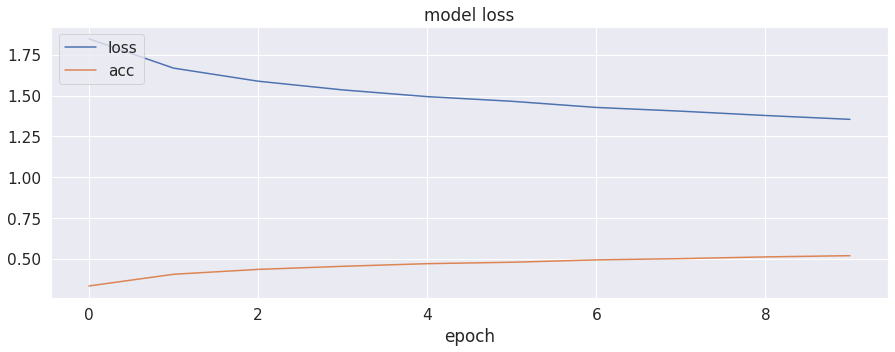

In [100]:
plt.plot(history_cifar.history['loss'], label = 'loss')
plt.plot(history_cifar.history['acc'], label = 'acc')
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['loss','acc'], loc ='upper left')
plt.show()

Evaluamos el modelo sobre el conjunto de test

In [101]:
test_cifar_loss, test_cifar_acc = model_cifar.evaluate(x_test_cifar, y_test_cifar)

print('\nError (loss) sobre el conjunto de test:',test_cifar_loss)
print('Rendimiento (accuracy) sobre el conjunto de test:',test_cifar_acc)

10000/10000 [==============================] - 1s 72us/step

Error (loss) sobre el conjunto de test: 1.4518098783493043
Rendimiento (accuracy) sobre el conjunto de test: 0.4856


Nos ha salido una medida de rendimiento cercana al 50%. No está mal, teniendo en cuenta que la red es muy simple y si eligiéramos al azar tendríamos una tasa de éxito del 10%. Podemos ver el resultado de algunas de las predicciones, dando contenido semántico a las etiquetas.

In [102]:
CLASSES = np.array(['aeroplano', 'automóvil', 'pájaro', 'gato', 'ciervo', 
                    'perro', 'rana', 'caballo', 'barco', 'camión'])


preds_cifar = model_cifar.predict(x_test_cifar)
preds_single_cifar = CLASSES[np.argmax(preds_cifar, axis = -1)]
actual_single_cifar = CLASSES[np.argmax(y_test_cifar, axis = -1)]

print('Predicción:',preds_single_cifar[:5])
print('Etiqueta real:', actual_single_cifar[:5])

Predicción: ['gato' 'camión' 'aeroplano' 'aeroplano' 'ciervo']
Etiqueta real: ['gato' 'barco' 'barco' 'aeroplano' 'rana']


Pero queda mejor si vemos las imágenes del conjunto de test, su etiqueta y el resultado de la predicción.

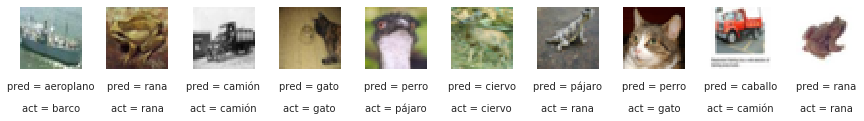

In [103]:
n_to_show = 10
indices = np.random.choice(range(len(x_test_cifar)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test_cifar[idx]
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'pred = ' + str(preds_single_cifar[idx]), fontsize=10, ha='center', transform=ax.transAxes) 
    ax.text(0.5, -0.7, 'act = ' + str(actual_single_cifar[idx]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img)